# Reference attack on ResNet-18 models for CIFAR-100 classification

We start by installing the required libraries, and importing them.

In [1]:
# %pip install /mnt/backup1/home/victor/ml_privacy_meter

In [2]:
from math import ceil
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch import nn, optim, Tensor
import tensorflow as tf
from torchvision import models

In [3]:
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import PytorchModel
from privacy_meter.hypothesis_test import threshold_func, gaussian_threshold_func
from privacy_meter.metric import ReferenceMetric
from privacy_meter.information_source_signal import ModelLoss
from privacy_meter import audit_report

We then fix the seed for reproducibility purposes.

In [4]:
np.random.seed(1234)

We now set the hyperparameters for both the training of the models and the reference attack.

In [5]:
num_points_per_train_split = 15_000
num_points_per_test_split = 5_000
loss_fn = nn.CrossEntropyLoss()
epochs = 50
batch_size = 256

num_reference_models = 24
fpr_tolerance_list = np.linspace(0, 1).tolist()

We then download and preprocess the CIFAR-100 dataset.

In [6]:
def preprocess_cifar100_dataset():
    input_shape, num_classes = (32, 32, 3), 100

    # split the data between train and test sets
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # switch channels to meet pytorch expectations
    x_train = np.moveaxis(x_train, -1, 1)
    x_test = np.moveaxis(x_test, -1, 1)

    y_train = y_train[:, 0]
    y_test = y_test[:, 0]

    return x_train, y_train, x_test, y_test, input_shape, num_classes

x_train_all, y_train_all, x_test_all, y_test_all, input_shape, num_classes = preprocess_cifar100_dataset()

And wrap it in the *Dataset* object from *privacy-meter*.

In [7]:
dataset = Dataset(
    data_dict={
        'train': {'x': x_train_all, 'y': y_train_all},
        'test': {'x': x_test_all, 'y': y_test_all}
    },
    default_input='x',
    default_output='y'
)

We then use a built-in function to create a target subset, and reference subsets. Using the hybrid method, there is no overlap between the target target subset and the reference subsets, but overlap between two reference subsets is authorized.

In [8]:
datasets_list = dataset.subdivide(
    num_splits=num_reference_models + 1,
    delete_original=True,
    in_place=True,
    return_results=True,
    method='hybrid',
    split_size={'train': num_points_per_train_split, 'test': num_points_per_test_split}
)

We now define the model architecture, in that case ResNet-18. Note that we **do not** use a pretrained version, to control members vs non-members.

In [9]:
def get_model():
    model_ft = models.resnet18(weights=None)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

This is a boilerplate PyTorch training loop.

In [10]:
def train_model(model, k, device):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
  x_train = dataset.get_feature(split_name=f'train{k:03d}', feature_name='<default_input>')
  y_train = dataset.get_feature(split_name=f'train{k:03d}', feature_name='<default_output>')
  x_test = Tensor(dataset.get_feature(split_name=f'test{k:03d}', feature_name='<default_input>')).to(device)
  y_test = Tensor(dataset.get_feature(split_name=f'test{k:03d}', feature_name='<default_output>')).to(int).to(device)
  n_samples = x_train.shape[0]
  n_batches = ceil(n_samples / batch_size)
  x_train = np.array_split(x_train, n_batches)
  y_train = np.array_split(y_train, n_batches)
  for epoch in range(epochs):
      epoch_loss, acc = 0.0, 0.0
      for b in range(n_batches):
          optimizer.zero_grad()
          y_pred = model(Tensor(x_train[b]).to(device))
          loss = loss_fn(y_pred, Tensor(y_train[b]).to(int).to(device))
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          acc += torch.sum(y_pred.argmax(axis=1) == Tensor(y_train[b]).to(int).to(device))
      acc /= n_samples
      epoch_loss /= n_samples
      y_pred = model(x_test)
      test_loss = loss_fn(y_pred, y_test)
      test_acc = torch.sum(y_pred.argmax(axis=1) == y_test) / x_test.shape[0]
      print(f'model #{k:02d}, epoch #{epoch:03d}:   train_acc={100*acc:05.1f}%   train_loss={epoch_loss:.2e}   test_acc={100*test_acc:05.1f}%   test_loss={test_loss:.2e}')
  return model.to("cpu")

We now execute the previously defined model-related functions, and wrap the results in *PytorchModel* objects from *privacy-meter*.

In [11]:
models = [
    PytorchModel(
        model_obj=train_model(get_model(), k, 'cuda:0'),
        loss_fn=loss_fn
    )
    for k in range(num_reference_models + 1)
]

model #00, epoch #000:   train_acc=006.1%   train_loss=1.73e-02   test_acc=010.6%   test_loss=4.04e+00
model #00, epoch #001:   train_acc=020.8%   train_loss=1.39e-02   test_acc=014.0%   test_loss=3.78e+00
model #00, epoch #002:   train_acc=038.4%   train_loss=1.14e-02   test_acc=016.0%   test_loss=3.67e+00
model #00, epoch #003:   train_acc=057.4%   train_loss=9.00e-03   test_acc=016.9%   test_loss=3.63e+00
model #00, epoch #004:   train_acc=073.6%   train_loss=6.89e-03   test_acc=017.0%   test_loss=3.64e+00
model #00, epoch #005:   train_acc=082.0%   train_loss=5.46e-03   test_acc=016.8%   test_loss=3.67e+00
model #00, epoch #006:   train_acc=086.8%   train_loss=4.44e-03   test_acc=016.8%   test_loss=3.71e+00
model #00, epoch #007:   train_acc=090.8%   train_loss=3.56e-03   test_acc=016.5%   test_loss=3.78e+00
model #00, epoch #008:   train_acc=094.6%   train_loss=2.69e-03   test_acc=016.5%   test_loss=3.87e+00
model #00, epoch #009:   train_acc=096.9%   train_loss=1.96e-03   test_ac

The *dataset* object is not needed anymore, let's delete it to free up some memory.

In [12]:
del dataset

We now combine the models and their associated training subsets into *InformationSource* from *privacy-meter*. *InformationSource* is a fundamental building block of the library, from which the auditing algorithms get all the required information.

In [13]:
target_info_source = InformationSource(
    models=[models[0]],
    datasets=[datasets_list[0]]
)

reference_info_source = InformationSource(
    models=models[1:],
    datasets=datasets_list[1:]
)

Finally, we can choose which one of the built-in metric we want to use (or define our own), and define an auditing strategy based on this.

In [14]:
metric = ReferenceMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelLoss()],
    hypothesis_test_func=gaussian_threshold_func,
    logs_dirname='./demo-logs'
)

audit_obj = Audit(
    metrics=metric,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)

The last step is to actually run the audit.

In [15]:
audit_obj.prepare()
audit_results = audit_obj.run()[0]

Results are stored in: ['/mnt/backup1/home/victor/log_2022-11-17_13-20-16-000']


To finish the demo, we can ask the *privacy-meter* library to plot to ROC curve based on the audit.

In [17]:
audit_report.REPORT_FILES_DIR = '/home/victor/backup/ml_privacy_meter/privacy_meter/report_files'

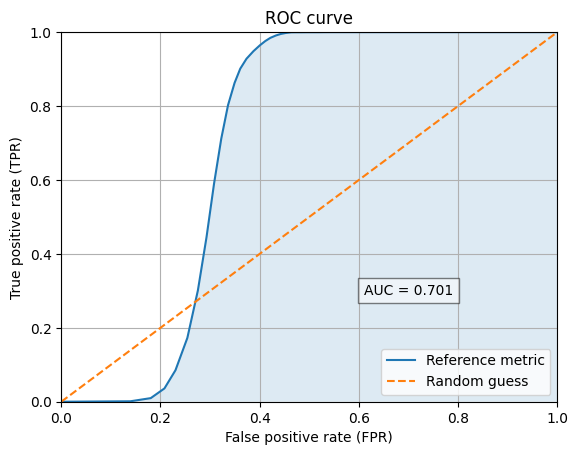

<Figure size 640x480 with 0 Axes>

In [19]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)